# DCGAN + conditional DCGAN


In this notebook will learn about Generative Adversarial Networks by implementing a DCGAN to generate images from noise, followed by a conditional DCGAN.

**Important:** Set the Colab environment to run on GPU

**Notebook created by [Daniel Fojo](https://www.linkedin.com/in/daniel-fojo/) for the [Postgraduate course in artificial intelligence with deep learning](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) in [UPC School](https://www.talent.upc.edu/ing/) (2020).**



In [ ]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets, utils
from PIL import Image
import numpy as np
import math
from IPython.display import display
from tqdm import tqdm
device = torch.device("cuda")

## Hyperparameters

In [ ]:
num_epochs = 300

lr = 0.0002
betas = (0.5, 0.999)

noise_size = 100
batch_size = 128
num_val_samples = 25
num_classes = 10
num_input_channels = 1

## Dataset
Download and prepare dataset


In [ ]:
train_transforms = transforms.Compose(
            [   
                transforms.Resize(32),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (.5,))
            ])
dataset = datasets.MNIST(root='data', train=True, transform=train_transforms, download=True)

## Data Loader
Create a data loader for the MNIST dataset

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# DCGAN

## Networks
First, lets define our simple generator

### Exercise 1

The generator takes random noise as input and gives an image as output. Your exercise is to create the generator model.

It should follow these guidelines:
* The input will be a vector with random noise of size `noise_size`
* You should first apply a fully connected with output size 512\*4\*4 (channels\*height\*width)
* Then you should apply 3 blocks of:
    * TransposedConvolution with kernel size 4, stride 2 and padding 1. For the first 2 blocks, the output channels should be 256 and 128. For the third block, the output channels should be the correct one to generate images of the dataset.
    * BatchNorm2d except for the last block.
    * ReLU activation for the first 2 blocks and Tanh for the third block.

**Hint**: Remember to use reshape where necessary

In [ ]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
      
        self.fc = ...

        self.convt1 = nn.Sequential(
            ...
            ...
            ...
        )
        self.convt2 = nn.Sequential(
            ...
            ...
            ...
        )
        self.convt3 = nn.Sequential(
            ...
            ...
        )

    def forward(self, x):

        ...
        
        return x

Similarly lets define a simple discriminator

### Exercise 2

The discriminator takes an image as input and classifies it between Real or Fake (1 or 0). Your exercise is to create the discriminator model.

It should follow these guidelines:
* The input will be an image of size `[num_input_channels, 32, 32]`
* You should apply 3 blocks of:
    * Convolution with kernel size 4, stride 2 and padding 1. The output channels should be 128, 256 and 512.
    * BatchNorm2d except for the first block.
    * LeakyReLU activation (alpha=0.2)
* Then you should first apply a fully connected with input size 512\*4\*4 (channels\*height\*width) and the correct output size and activation for binary classification


**Hint**: Remember to use reshape/flatten where necessary

In [ ]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            ...
            ...
        )
        self.conv2 = nn.Sequential(
            ...
            ...
            ...
        )
        self.conv3 = nn.Sequential(
            ...
            ...
            ...
        )
        
        self.fc = nn.Sequential(
            ...
            ...
        )

    def forward(self, x):

        ...
        
        return x

In [ ]:
generator = Generator().to(device)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)

discriminator = Discriminator().to(device)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

criterion = nn.BCELoss()

def init_weights(m):
    if type(m) in {nn.Conv2d, nn.ConvTranspose2d, nn.Linear}:
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias != None:
            torch.nn.init.constant_(m.bias, 0.0)
    if type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

generator.apply(init_weights)
discriminator.apply(init_weights);


## Train function

### Exercise 3

Complete the code. Take into account which labels should be used at each step of the training.

In [ ]:
def train_batch(real_samples, generator, discriminator, optimizer_g, optimizer_d):

    generator.train()
    discriminator.train()
    
    current_batch_size = real_samples.shape[0]
    label_real = torch.ones(current_batch_size, 1, device=device)
    label_fake = torch.zeros(current_batch_size, 1, device=device)

    ####################
    # OPTIMIZE GENERATOR
    ####################

    # Reset gradients
    optimizer_g.zero_grad()

    # Generate fake samples
    z = torch.randn(current_batch_size, noise_size, device=device)
    fake_samples = generator(z)
    
    # Evaluate the generated samples with the discriminator
    predictions_g_fake = discriminator(fake_samples)

    # Calculate error with respect to what the generator wants
    loss_g = ...

    # Backpropagate
    loss_g.backward()
    
    # Update weights
    optimizer_g.step()
    
    ########################
    # OPTIMIZE DISCRIMINATOR
    ########################
    
    fake_samples = fake_samples.detach()
    
    # Reset gradients
    optimizer_d.zero_grad()

    # Calculate discriminator prediction for real samples
    predictions_d_real = discriminator(real_samples)  

    # Calculate error with respect to what the discriminator wants
    loss_d_real = ...

    # Calculate discriminator loss for fake samples
    predictions_d_fake = discriminator(fake_samples)

    # Calculate error with respect to what the discriminator wants
    loss_d_fake = ...
    
    # Total discriminator loss
    loss_d = (loss_d_real + loss_d_fake) / 2
    loss_d.backward()

    optimizer_d.step()

    return loss_g.item(), loss_d.item()


## Evaluation function

In [ ]:
@torch.no_grad()
def evaluate(generator, z_val):
    generator.eval()
    fake_samples = generator(z_val).cpu()
    # select a sample or create grid if img is a batch
    nrows = int(math.sqrt(fake_samples.shape[0]))
    img = utils.make_grid(fake_samples, nrow=nrows)

    # unnormalize
    img = (img*0.5 + 0.5)*255

    # to numpy
    image_numpy = img.numpy().astype(np.uint8)
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    return Image.fromarray(image_numpy)


## Train loop

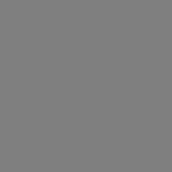

epoch: 1/300 batch: 1/469 G_loss: 0.6909956336021423, D_loss: 0.6923298239707947


KeyboardInterrupt: ignored

In [ ]:
z_val = torch.randn(num_val_samples, noise_size, device=device)

for epoch in range(num_epochs):

    for i, (real_samples, labels) in enumerate(dataloader):
        real_samples = real_samples.to(device)
        loss_g, loss_d = train_batch(real_samples, generator, discriminator, optimizer_g, optimizer_d)

        if i % 100 == 0:
            fake_images = evaluate(generator, z_val)
            display(fake_images)

            # Show current loss
            print(f"epoch: {epoch+1}/{num_epochs} batch: {i+1}/{len(dataloader)} G_loss: {loss_g}, D_loss: {loss_d}")


# Extra: Conditional GAN

## Networks

### Exercise 4

We will now modify the generator from before to a conditional generator. To do it, we will concatenated the input to the convolutions with an embedding of the label we want to generate.

Complete the forward method. To do it, use the embedding layer with the label, and then use `torch.cat` to concatenate the label as a channel (after the corresponding `reshape`)

**Hint**: The embedding is concatenated as a new channel.

In [ ]:
class ConditionalGenerator(torch.nn.Module):
    
    def __init__(self):
        super().__init__()

        self.fc = torch.nn.Linear(noise_size, 512*4*4)

        self.embedding = nn.Embedding(num_classes, 4*4)

        self.convt1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512+1, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.convt2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=num_input_channels, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, x, label):
        x = self.fc(x)
        x = x.reshape(x.shape[0], 512, 4, 4)

        ...

        x = self.convt1(x)
        x = self.convt2(x)
        x = self.convt3(x)
        return x


### Exercise 5

We will now modify the discriminator from before to a conditional discriminator. To do it, we will concatenated the input image with an embedding of the label we want to generate.

Complete the forward method. To do it, use the embedding layer with the label, and then use `torch.cat` to concatenate the label as a channel (after the corresponding `reshape`)

**Hint**: The embedding is concatenated as a new channel.

In [ ]:
class ConditionalDiscriminator(torch.nn.Module):
    
    def __init__(self):
        super().__init__()

        self.embedding = nn.Embedding(num_classes, 32*32)
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=num_input_channels+1, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x, label):


        ...


        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x


In [ ]:
generator = ConditionalGenerator().to(device)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)

discriminator = ConditionalDiscriminator().to(device)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

criterion = nn.BCELoss()

def init_weights(m):
    if type(m) in {nn.Conv2d, nn.ConvTranspose2d, nn.Linear}:
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias != None:
            torch.nn.init.constant_(m.bias, 0.0)
    if type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

generator.apply(init_weights)
discriminator.apply(init_weights);


## Train function

In [ ]:
def train_batch_conditional(real_samples, real_labels, generator, discriminator, optimizer_g, optimizer_d):

    generator.train()
    discriminator.train()
    current_batch_size = real_samples.shape[0]
    label_real = torch.ones(current_batch_size, 1, device=device)
    label_fake = torch.zeros(current_batch_size, 1, device=device)

    ####################
    # OPTIMIZE GENERATOR
    ####################

    # Reset gradients
    optimizer_g.zero_grad()

    # Generate fake samples
    z = torch.randn(current_batch_size, noise_size, device=device)
    fake_labels = torch.randint(0, 10, size=(current_batch_size, 1), device=device)
    fake_samples = generator(z, fake_labels)
    
    # Evaluate the generated samples with the discriminator
    predictions_g_fake = discriminator(fake_samples, fake_labels)

    # Calculate error with respect to what the generator wants
    loss_g = criterion(predictions_g_fake, label_real)

    # Backpropagate
    loss_g.backward()
    
    # Update weights
    optimizer_g.step()

    ####################
    # OPTIMIZE DISCRIMINATOR
    ####################

    fake_samples = fake_samples.detach()
    # Reset gradients
    optimizer_d.zero_grad()

    # Calculate discriminator prediction for real samples
    predictions_d_real = discriminator(real_samples, real_labels)  

    # Calculate error with respect to what the discriminator wants
    loss_d_real = criterion(predictions_d_real, label_real)

    # Calculate discriminator loss for fake samples
    predictions_d_fake = discriminator(fake_samples, fake_labels)

    # Calculate error with respect to what the discriminator wants
    loss_d_fake = criterion(predictions_d_fake, label_fake)
    
    # Total discriminator loss
    loss_d = (loss_d_real + loss_d_fake) / 2
    loss_d.backward()

    optimizer_d.step()

    return loss_g.item(), loss_d.item()


## Evaluation function

In [ ]:
@torch.no_grad()
def evaluate_conditional(generator, z_val, labels_val):
    generator.eval()
    fake_samples = generator(z_val, labels_val).cpu()
    # select a sample or create grid if img is a batch
    nrows = int(math.sqrt(fake_samples.shape[0]))
    img = utils.make_grid(fake_samples, nrow=nrows)

    # unnormalize
    img = (img*0.5 + 0.5)*255

    # to numpy
    image_numpy = img.numpy().astype(np.uint8)
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    return Image.fromarray(image_numpy)


## Train loop

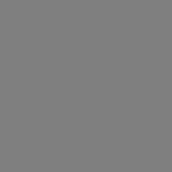

epoch: 1/300 batch: 1/469 G_loss: 0.6925517320632935, D_loss: 0.6937770843505859


In [ ]:
from itertools import cycle

z_val = torch.randn(num_val_samples, noise_size, device=device)
labels_cycle = cycle(range(num_classes))
labels_val = torch.tensor([next(labels_cycle) for i in range(num_val_samples)], device=device).unsqueeze(1)
for epoch in range(num_epochs):

    for i, (real_samples, real_labels) in enumerate(dataloader):
        real_samples = real_samples.to(device)
        real_labels = real_labels.unsqueeze(1).to(device)
        loss_g, loss_d = train_batch_conditional(real_samples, real_labels, generator, discriminator, optimizer_g, optimizer_d)

        if i % 100 == 0:
            fake_images = evaluate_conditional(generator, z_val, labels_val)
            display(fake_images)

            # Show current loss
            print(f"epoch: {epoch+1}/{num_epochs} batch: {i+1}/{len(dataloader)} G_loss: {loss_g}, D_loss: {loss_d}")
